In [1]:
import numpy as np
import numpy.fft as nf
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as sc
import time as time
import os
import matplotlib as mpl
from matplotlib import cm

options = qt.Options()
options.nsetps = 10000

plt.style.use('ggplot')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def hilbert(Na=15):
    ''' '''
    global I2, Ia, sm, sx, sz, a, II, vac, p_g, p_e
    
    I2 = qt.qeye(2)
    Ia = qt.qeye(Na)

    sm = qt.tensor(Ia, qt.sigmam())
    sx = qt.tensor(Ia, qt.sigmax())
    sz = qt.tensor(Ia, qt.sigmaz())
    a  = qt.tensor(qt.destroy(Na), I2)
    II = qt.tensor(Ia, I2)

    g_q = qt.basis(2,1)
    e_q = qt.basis(2,0)
    vac = qt.tensor(qt.basis(Na,0), g_q)
    p_g = qt.tensor(Ia, g_q*g_q.dag())
    p_e = qt.tensor(Ia, e_q*e_q.dag())
    
    dim = 2*Na
    print('dim(H) = %.f'%dim)

def state(n, gnd_or_exc):
    ''' '''
    if gnd_or_exc is 'exc':
        psi = sm.dag()*vac
    elif gnd_or_exc is 'gnd':
        psi = vac
    else:
        raise ValueError('Poor state definition')
    for ii in range(n):
        psi = a.dag()*psi
    return psi/psi.norm()


class system(object):

    def __init__(self, w_qubit=6e3, g=1e-1, gamma=5e0, kappa=5e0, e_drive=2e0, **kwargs):
        
        self.args = {'w_qubit': w_qubit,
                     'w_cav'  : w_qubit,
                     'g'      : g,
                     'gamma'  : gamma,
                     'kappa'  : kappa,
                     'w_pump' : 2*w_qubit+0.00001,
                     'e_pump' : 0,
                     'w_drive': w_qubit,
                     'e_drive': e_drive,
                     **kwargs}
        self.driv = {}         # filled when calling time_gen
        self.operators = {}    # filled when calling Dynamics
        
        for keys in self.args.keys():
            self.args[keys] = 2*np.pi*self.args[keys]
            
        self._compute()
    
            
    def _compute(self):
        ''' By default, all these parameters must be computed after the fact '''
        ''' They shall not be input parameters '''
        self.args['d_cp'] = self.args['w_cav'] - self.args['w_pump']/2
        self.args['d_qp'] = self.args['w_qubit'] - self.args['w_pump']/2
        self.args['r']    = self.r_param()
        self.args['SdB']  = self.Squeez()
        self.args['O']    = self.Omega()
        Na = a.dims[0][0]
        self.operators['U'] = qt.tensor(qt.squeeze(Na, self.args['r']), I2)

    def twopi_update(self, dic):
        ''' Takes care of the two pis '''
        for keys in dic.keys():
            dic[keys] *= 2*np.pi
        self.args.update(dic)
        self._compute()
        
    def freqs(self, key):
        ''' Returns a frequency '''
        return self.args[key]/2/np.pi
            
    def print_args(self, where):
        ''' Self-explanatory '''
        skip  = ['e_drive', 'w_drive', 'gamma', 'kappa']
        title = ''
        if where is 'inline':
            largs = {'w_qubit':'wq', 'w_cav':'wc', 'g':'g',
                     'gamma':'gamma', 'kappa':'kappa',
                     'w_pump':'wp', 'e_pump':'ep',
                     'w_drive':'wd', 'e_drive':'ed',
                     'd_cp':'dcp', 'd_qp':'dqp',
                     'r':'r', 'O':'Omega', 'SdB':'SdB'}
        elif where is 'plot':
            largs = {'w_qubit':r'$\omega_q$', 'w_cav':r'$\omega_c$', 'g':r'$g$',
                     'gamma':r'$\gamma$', 'kappa':r'$\kappa$',
                     'w_pump':r'$\omega_p$', 'e_pump':r'$\varepsilon_p$',
                     'w_drive':r'$\omega_d$', 'e_drive':r'$\varepsilon_d$',
                     'd_cp':r'$\delta_{c-p}$', 'd_qp':r'$\delta_{q-p}$',
                     'r':r'$r$', 'O':r'$\Omega$', 'SdB':r'$S_{dB}$'}
        for keys in self.args.keys():
            val = self.args[keys]/2/np.pi
            if keys is 'r':
                val *= 2*np.pi
            if (keys in skip):
                continue
            elif keys is 'e_pump':
                title += largs[keys]+'=%.4f,  '%val
            else:
                title += largs[keys]+'=%.2f,  '%val
        return title[:-3]      
        
    def w_larmor(self):
        ''' Larmor frequency '''
        ''' Must be called after time_gen '''
        ''' w_drive is a np.array() '''
        ed = self.driv['e_drive']
        wq = self.args['w_qubit']
        wd = self.driv['w_drive']
        return np.sqrt(ed**2+(wq-wd)**2)

    def p_rabi(self):
        ''' Maximum excited probability for dissipation-less system '''
        ''' Must be called after time_gen '''
        ''' w_drive is a np.array() '''
        ed = self.driv['e_drive']
        wq = self.args['w_qubit']
        wd = self.driv['w_drive']
        return (ed/w_larmor(args))**2

    def Purcell(self):
        ''' Purcell broadening '''
        k  = self.args['kappa']
        g  = self.args['g']
        wq = self.args['w_qubit']
        wc = self.args['w_cav']
        return k*g**2/(k**2/4+(wq-wc)**2)

    def r_param(self):
        ''' r param in Leroux '''
        ep = self.args['e_pump']
        dc = self.args['d_cp']
        return (1/2)*np.arctanh(ep/dc)

    def Omega(self):
        ''' Omega in Leroux '''
        dc = self.args['d_cp']
        r  = self.r_param()
        return dc/np.cosh(2*r) 

    def Squeez(self):
        ''' S = e^(2r) expressed in dB'''
        r  = self.r_param()
        return 10*np.log10(np.exp(2*r))

    def Lambda(self):
        ''' Lambda = e_pump '''
        ''' Careful, e_pump must be defined first '''
        dc = self.args['d_cp']
        return d_c*np.tanh(np.log(10**(Squeez(self)/10)))
    


    def Dynamics(self, Htype, Dtype, isDrive=False, nth=0):
        
        def Hd_coeff(t, args=self.args):
            ''' Cosine drive '''
            ''' (1/2) mimicks an exp(1j*w*t) drive in the spin locked frame '''
            return (1/2)*args['e_drive']*np.cos(args['w_drive']*t)
        
        def Hp_coeff(t, args=self.args):
            ''' Cosine drive '''
            ''' (-1) mimicks an (-1/2)*exp(1j*w*t) drive in the spin locked frame '''
            return (-1)*args['e_pump']*np.cos(args['w_pump']*t)
        
        def D0_coeff(t, args=self.args):
            ''' Qubit relaxation '''
            return np.sqrt(args['gamma'])

        def Da_coeff(t, args=self.args):
            ''' Cav relaxation '''
            return np.sqrt(args['kappa'])

#        print(self.r_param())
        
        if Htype is 'TLS':
            ''' '''
            H0 = self.args['w_qubit']*sz/2
            Hd = sx
            Hr = self.args['e_drive']/2*sx
            H  = [H0]
            if isDrive: H.append([Hd,Hd_coeff])
            
        elif Htype is 'Rabi':
            ''' '''
            H0 = self.args['w_qubit']*sz/2
            Ha = self.args['w_cav']*a.dag()*a
            Hc = self.args['g']*(a+a.dag())*sx
            Hd = a+a.dag()
            H  = [H0+Ha+Hc]
            if isDrive: H.append([Hd,Hd_coeff])
            
        elif Htype is 'JC':
            ''' Well-known Jesus-Christ Hamiltonian '''
            H0 = 0*II #self.args['w_qubit']*sz/2
            Ha = (self.args['w_cav']-self.args['w_qubit'])*a.dag()*a
            Hc = self.args['g']*(a*sm.dag()+a.dag()*sm)
            Hd = a+a.dag()
            H  = [H0+Ha+Hc]
            if isDrive: H.append([Hd,Hd_coeff])
            
        elif Htype is 'LRlab':
            ''' eqn (S8) '''
            H0 = self.args['w_qubit']*sz/2
            Ha = self.args['w_cav']*a.dag()*a
            Hc = self.args['g']*(a*sm.dag()+a.dag()*sm)
            Hd = a+a.dag()
            Hp = a**2+a.dag()**2
            H  = [H0+Ha+Hc,[Hp,Hp_coeff]]
            if isDrive: H.append([Hd,Hd_coeff])
        
        elif Htype is 'LRrot': #pump
            ''' eqn (1) '''
            H0 = (self.args['d_qp'])*sz/2
            Ha = (self.args['d_cp'])*a.dag()*a
            Hc = self.args['g']*(a*sm.dag()+a.dag()*sm)
            Hp = (-1/2)*self.args['e_pump']*(a**2+a.dag()**2)
            Hd = a+a.dag()
            H  = [H0+Ha+Hc+Hp]
            if isDrive: H.append([Hd,Hd_coeff])
            
        elif Htype is 'LRsqueez':
            ''' eqn (3) '''
            H0 = (self.args['d_qp'])*sz/2
            Ha = (self.Omega())*a.dag()*a 
            Hc = (self.args['g']/2)*np.exp(self.r_param())*(a+a.dag())*sx
            HE = (-self.args['g']/2)*np.exp(-self.r_param())*(a.dag()-a)*(sm.dag()-sm)
            HD = 0*II
            Hd = a+a.dag()
            H  = [H0+Ha+Hc+HE+HD]
            if isDrive: H.append([Hd,Hd_coeff])
                
        elif Htype is 'LRUsqueez':
            ''' U * eqn (1) * U.dag() '''
            H0 = (self.args['d_qp'])*sz/2
            Ha = (self.args['d_cp'])*a.dag()*a
            Hc = self.args['g']*(a*sm.dag()+a.dag()*sm)
            Hp = (-1/2)*self.args['e_pump']*(a**2+a.dag()**2)
            Hd = a+a.dag()
            U  = self.operators['U']
            H  = [U*(H0+Ha+Hc+Hp)*U.dag()]
            if isDrive: H.append([Hd,Hd_coeff])
        
        self.operators.update(H = H)
        
        ### NO PHASE DAMPING np.sqrt(gamma_phi/2)*sz
        D = []
        if Dtype is 'regular':
            D.append(np.sqrt(sys.args['gamma']*(1+nth))*sm)
            D.append(np.sqrt(sys.args['gamma']*nth)*sm.dag())
            D.append(np.sqrt(sys.args['kappa']*(1+nth))*a)
            D.append(np.sqrt(sys.args['kappa']*nth)*a.dag())
            
        elif Dtype is 'weird':
            r = self.r_param()
            D.append(np.sqrt(sys.args['gamma']*(1+nth))*sm)
            D.append(np.sqrt(sys.args['gamma']*nth)*sm.dag())
            D.append(np.sqrt(sys.args['kappa'])*a)
            kp = sys.args['kappa']*(nth+np.sinh(r))*np.exp(+r)/2
            km = sys.args['kappa']*(nth-np.sinh(r))*np.exp(-r)/2
            D.append(np.sqrt(kp)*(a+a.dag()))
            D.append(np.sign(km)*np.sqrt(np.abs(km))*(a-a.dag())) 
            
        elif Dtype is 'Uweird':
            d = np.sqrt(sys.args['gamma']*(1+nth))*sm
            d+= np.sqrt(sys.args['gamma']*nth)*sm.dag()
            d+= np.sqrt(sys.args['kappa']*(1+nth))*a
            d+= np.sqrt(sys.args['kappa']*nth)*a.dag()
            U = self.operators['U']
            D.append(U*d*U.dag())
            
        self.operators.update(D = D)

#########################################
# Analysis
#########################################

def func_cos(x, w, phi, A, C):
    return A*np.cos(w*x+phi)+C

def fit_cos(x, y, printing=False):
    ''' Use Fourier Transform to feed initial values to cosine fit '''
    y_mean = np.mean(y)
    y_fft  = nf.rfft(y-y_mean, norm='ortho')
    freqs  = nf.rfftfreq(len(x), x[1]-x[0])
    i_gues = np.argmax(np.abs(y_fft))
    w_gues = 2*np.pi*freqs[i_gues]
    p_gues = np.pi*(1-np.sign(np.real(y_fft[i_gues])))/2
    A_gues = (np.max(y) - np.min(y))/2
    p0     = [w_gues, p_gues, A_gues, y_mean]
    popt, pcov = sc.curve_fit(func_cos, x, y, p0=p0)
    if printing:
        print('guess: ', np.round(p0,3))
        print('fit:   ', np.round(popt,3))
        print('------------------------')
    return popt, pcov

def func_lor(x, x0, gamma, A):
    return A/(1+((x-x0)*2/gamma)**2)

def func_double_lor(x, x0, gamma, A, g):
    return A/2*( 1/(1+((x-x0-g)*2/gamma)**2) + 1/(1+((x-x0+g)*2/gamma)**2) )

def func_double_decay(x, x0, gamma1, gamma2, A1, A2):
    return A1/(1+((x-x0)*2/gamma1)**2) + A2/(1+((x-x0)*2/gamma2)**2)


#########################################
# Absorption Spectrum
#########################################

def time_gen(sys, sp=3, N=11, nmax=5000):
    ''' Construction of the drive and time lists: '''
    ''' Crucially one must resolve the drive frequency according to Shannon criteria, '''
    ''' which sets 'tstep'. Ideally the slow dynamics should also be captured, which '''
    ''' sets 'tmax', but the number of points is limited to 'nmax' '''

    wq = sys.args['w_qubit']
    ga = sys.args['gamma']
    ed = sys.args['e_drive']
    g  = sys.args['g']
    gp = sys.Purcell()
#    ge = g*np.exp(sys.r_param())

    if ga < ed:
        print('Time list generator: expect Power Broadening')

    wspan = max(ga, ed, g)*sp
    wslow = ga

    wdriv = np.linspace(wq-wspan, wq+wspan, N)
    tstep = 2*np.pi/(2*wdriv[-1])
    tmax  = 2*np.pi/wslow
    nopt  = 2*int(tmax/tstep)
    n     = min(nopt, nmax)
    times = np.linspace(0, n*tstep, n+1)

    sys.driv = {}
    sys.driv['w_drive'] = wdriv
    sys.driv['tstep']   = tstep
    sys.driv['tmax']    = tmax
    sys.driv['nopt']    = nopt
    sys.driv['n']       = n
    sys.driv['times']   = times

    return times

def absorption_spectrum(sys, N=11, sp=3, nmax=5000, printing=False):
    ''' Generate the absorption spectrum of the Qubit for N drives '''
    ''' centered around w_qubit with span +/- sp*gamma '''
    
    H    = sys.operators['H']
    psi0 = vac
    D    = sys.operators['D']
    obs  = [sm*sm.dag()]
    
    times = time_gen(sys, N=N, sp=sp, nmax=nmax)
    freqs = nf.rfftfreq(len(times), times[1]-times[0])
    
    alert = 0
    if sys.driv['n'] is nmax:
        alert = 1
    print(sys.driv['n'], 'bins:', end='')
    start = time.time()
    
    s_abs = np.zeros(N)
    for ii, wd in enumerate(sys.driv['w_drive']):
        startloop = time.time()
        sys.args.update({'w_drive':wd})
        result    = qt.mesolve(H, psi0, times, D, obs, args=sys.args, options=options)  
        smsp_fft  = nf.rfft(result.expect[0], norm='ortho')
        ii_wd     = np.argmin(np.abs(freqs-wd/2/np.pi))
        s_abs[ii] = np.abs(smsp_fft[ii_wd])
        
        if printing and ii in [int(N/4), int(N/2)]:
            fig, ax = plt.subplots(1,2, figsize=(12,4))
            ax[0].plot(times, result.expect[0])
            ax[0].set_ylabel(r'$<\sigma_-\sigma_+>$')
            ax[0].grid(linestyle='--')
            ax[1].plot(freqs[:], np.abs(smsp_fft[:]))
            ax[1].plot(f=abel(r'|TF $[<\sigma_-\sigma_+>]$|'))
            ax[1].grid(linestyle='--')
            ax[1].set_ylim([np.abs(smsp_fft[ii_wd])*(-0.1),np.abs(smsp_fft[ii_wd])*20])
#            title = r'$\omega_d=$%.2f, $\varepsilon_d=$%.2f'%(wd/2/np.pi, edrive)
            fig.suptitle(sys.print_args('plot'))

    if alert:
        print(' ', np.round(time.time()-start,1),'s - nmax reached ', str(sys.driv['nopt']))
    else:
        print(' ', np.round(time.time()-start,1),'s')
            
    return sys.driv['w_drive'], s_abs

def qubit_spectrum(sys, wlist, solver='es'):
    
    H   = sys.operators['H'][0]
    D   = sys.operators['D']
    A   = sm
    B   = sm.dag()
    
    return qt.spectrum(H, wlist, D, A, B, solver=solver)

def steadystate(sys, method='direct', solver=None):
    
    H   = sys.operators['H'][0]
    D   = sys.operators['D']
    
    return qt.steadystate(H, D, method='direct', solver=None)


#########################################
# Eigenspectrum
#########################################

def eigenspectrum(sys, Htype, sweep_key, sweep_key_list):
    
    nrj_list, state_list = [], []
    for ii, kk in enumerate(sweep_key_list):
        args = sys.twopi_update({sweep_key:kk})
#        print(sys.print_args('inline'))
        sys.Dynamics(Htype, isD=False)
        Ham = sys.operators['H'][0]
        nrj, state = Ham.eigenstates()
        nrj_list.append(nrj)
        state_list.append(state)
    nrj_list   = np.array(nrj_list).T/2/np.pi
    state_list = np.array(state_list).T
    
    return nrj_list, state_list


def feeder(S, d_cp, w_cav, printing=True):
    
    r_para = (1/2)*np.log(10**(S/10))
    Omega   = d_cp/np.cosh(2*r_para)
    if printing:
        print('feeder: r=%.2f, Omega=%.2f'%(r_para,Omega))
    e_pump  = d_cp*np.tanh(2*r_para)
    w_pump  = (w_cav-d_cp)*2
    
    return e_pump, w_pump





- Checking Hilbert space dimension using qubit spectrum
- Any Dynamics qubit spectrum vs Squeezing & Fitting
- All 3 Dynamic qubit spectra & comparison
- All 3 Dynamics steadystate & comparison
- Steadystate Wigners
- ...
- Plotting some parameters vs some others
- VRS for Jaynes-Cummings
- ... (limb, do not go there)

In [6]:
a.dims[0][0]

NameError: name 'a' is not defined

In [238]:
d = {'a':1, 'b':2}
for key,val in d.items():
    exec(key + '=val')

In [240]:
a

1

In [2]:
''' Checking Hilbert space dimension using qubit absorption spectra '''
# Set parameters
Ltype = 'Squeeze'
dims  = [5,10,15,20,25] #,30,35,40]
w_cav = 6e3
d_cp  = 1e3
gamma = 1e-3*d_cp
g     = 1*gamma
S     = 0

# Do not touch
span  = 50
w_drive_list = []
sreg_list, sweird_list = [], []
for ii, dim in enumerate(dims):
    hilbert(dim)
    sys   = system(w_cav=w_cav, g=g, gamma=gamma, kappa=gamma)
    print('------------------------')
    e_pump, w_pump = feeder(S, d_cp, w_cav)
    sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
    sys.args.update(d_qp=sys.Omega())
    
    w_drive = -sys.Omega() + sys.args['gamma']*np.linspace(-span,span,1001)
#    w_drive = 2*np.pi*np.linspace(-15e3,15e3,50001)
    w_drive_list.append(w_drive)
    
    if Ltype is 'Hybrid':
        sys.Dynamics(Htype='LRsqueez', Dtype='regular', isDrive=False)
    elif Ltype is 'Squeeze':
        sys.Dynamics(Htype='LRsqueez', Dtype='weird', isDrive=False)
    elif Ltype is 'Pump':
        sys.Dynamics(Htype='LRrot', Dtype='regular', isDrive=False)
    sweird_list.append(qubit_spectrum(sys, w_drive, solver='es'))
    
print('done')

dim(H) = 10
------------------------
feeder: r=0.00, Omega=1000.00
dim(H) = 20
------------------------
feeder: r=0.00, Omega=1000.00
dim(H) = 30
------------------------
feeder: r=0.00, Omega=1000.00
dim(H) = 40
------------------------
feeder: r=0.00, Omega=1000.00
dim(H) = 50
------------------------
feeder: r=0.00, Omega=1000.00
done


feeder: r=0.00, Omega=1000.00
feeder: r=0.00, Omega=1000.00
feeder: r=0.00, Omega=1000.00
feeder: r=0.00, Omega=1000.00
feeder: r=0.00, Omega=1000.00


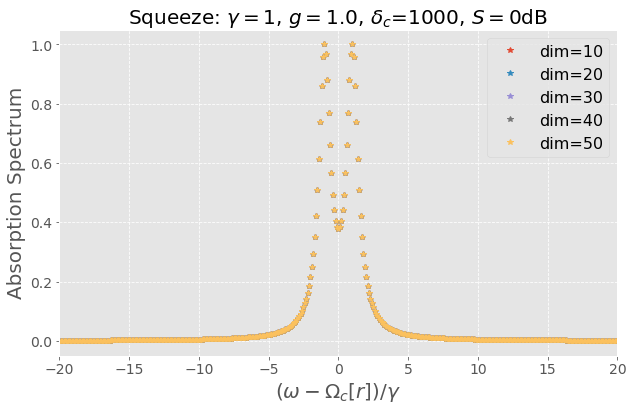

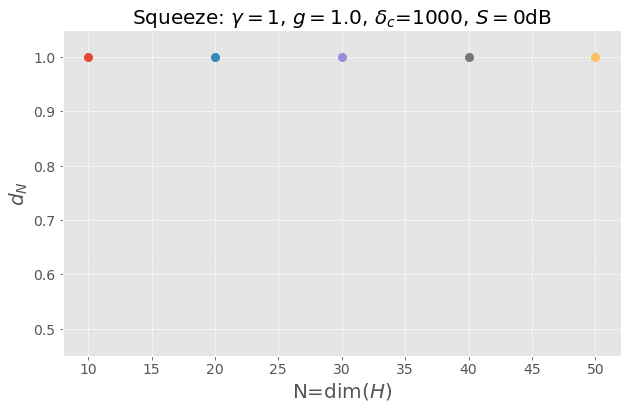

In [3]:
''' Plotting '''
fig1, ax1 = plt.subplots(1, figsize=(10,6))
fig2, ax2 = plt.subplots(1, figsize=(10,6))
fitting = False
saving  = False

dist    = np.zeros(len(dims))
for ii, dim in enumerate(dims):
    e_pump, w_pump = feeder(S, d_cp, w_cav)
    sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
        
    wdriv = w_drive_list[ii]
    xaxis = (wdriv+sys.Omega())/sys.args['gamma']
#    xaxis = wdriv/2/np.pi
    s_abs = sweird_list[ii]/np.max(sweird_list[ii])
    ax1.plot(xaxis, s_abs, '*', label='dim=%.f'%(2*dim), color='C'+str(ii))

    if fitting:
        p0 = [-sys.Omega(),
              sys.args['gamma'],
              1,
              sys.args['g']*np.exp(sys.r_param())]

        popt, pcov = sc.curve_fit(func_double_lor, wdriv, s_abs, p0=p0)
        ax1.plot(xaxis, func_double_lor(wdriv,*popt), '--', color='C'+str(ii))
        print(np.array(p0)/2/np.pi)
        print(np.array(popt)/2/np.pi)
    
    if ii-len(dims)+1:
        s_next = sweird_list[ii+1]/np.max(sweird_list[ii+1])
    else:
        s_next = s_abs
    dist[ii] = sum(s_abs/s_next)/len(s_abs)
    ax2.plot(2*dims[ii], dist[ii], 'o', markersize=8)

ax1.set_xlim([-20,20])

ax1.set_ylabel(r'Absorption Spectrum')
ax1.grid(linestyle='--')
ax1.set_xlabel(r'$(\omega-\Omega_c[r])/\gamma$')
ax1.legend()
ax1.set_title(Ltype+r': $\gamma=$%.f, $ g=$%.1f, $ \delta_c$=%.f, $ S=$%.fdB'%(gamma,g,d_cp,S))

ax2.set_ylabel(r'$d_N$')
ax2.grid(linestyle='--')
ax2.set_xlabel(r'N=dim($H$)')
ax2.set_ylim([0.45,1.05])
ax2.set_title(Ltype+r': $\gamma=$%.f, $ g=$%.1f, $ \delta_c$=%.f, $ S=$%.fdB'%(gamma,g,d_cp,S))

plt.show()
if saving:
    fig1.tight_layout()
    fig1.savefig('truncation_'+Dtype+'_piSolver_g%.1f_S%.fdB.png'%(g,S))
    fig2.tight_layout()
    fig2.savefig('distance_'+Dtype+'_piSolver_g%.1f_S%.fdB.png'%(g,S))

In [153]:
''' Any Dynamics qubit spectrum vs Squeezing & Fitting '''

# Set parameters
Ltype = 'Squeeze'
Slist = np.array([0,3,6,9])
Na    = 30
w_cav = 6e3
d_cp  = 1e3
gamma = 1e-3*d_cp
g     = 0.2*gamma

# Do not touch
hilbert(Na)
sys   = system(w_cav=w_cav, g=g, gamma=gamma, kappa=gamma)
span  = 50
wlist, stype = [], []
for ii, S in enumerate(Slist):
    print('------------------------')
    e_pump, w_pump = feeder(S, d_cp, w_cav)
    sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
    sys.args.update(d_qp=sys.Omega())
#    print(sys.print_args('inline'))

    wdrive = -sys.Omega() + sys.args['gamma']*np.linspace(-span,span,1001)
#    wdrive = 2*np.pi*np.linspace(-1.1e3,0.1e3,50001)
    wlist.append(wdrive)
    
    if Ltype is 'Hybrid':
        sys.Dynamics(Htype='LRsqueez', Dtype='regular', isDrive=False)
    elif Ltype is 'UHybrid':
        sys.Dynamics(Htype='LRUsqueez', Dtype='regular', isDrive=False)
    elif Ltype is 'Pump':
        sys.Dynamics(Htype='LRrot', Dtype='regular', isDrive=False)
    elif Ltype is 'Squeeze':
        sys.Dynamics(Htype='LRsqueez', Dtype='weird', isDrive=False)
    stype.append(qubit_spectrum(sys, wdrive, solver='es'))
    
print('done')

dim(H) = 40
------------------------
feeder: r=0.00, Omega=1000.00
------------------------
feeder: r=1.15, Omega=198.02
------------------------
feeder: r=1.73, Omega=63.18
done


feeder: r=0.00, Omega=1000.00
feeder: r=1.15, Omega=198.02
feeder: r=1.73, Omega=63.18


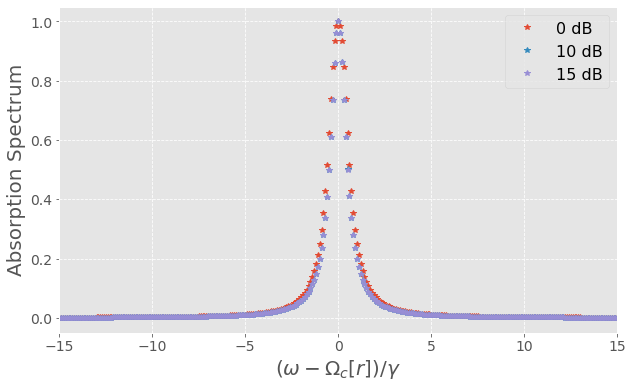

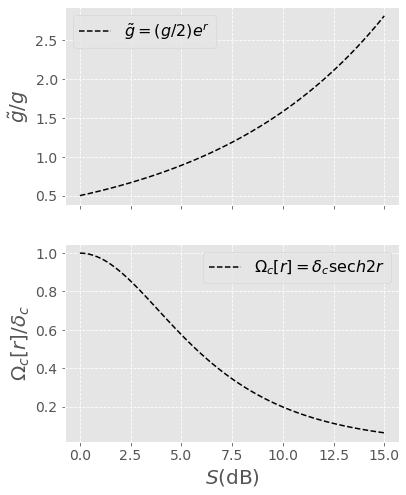

In [154]:
''' Plotting '''
fig1, ax1 = plt.subplots(1, figsize=(10,6))
fig2, ax2 = plt.subplots(2,1, figsize=(6,8))
fitting = False
saving  = False
for ii, S in enumerate(Slist):
    e_pump, w_pump = feeder(S, d_cp, w_cav)
    sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
    
    wdriv = wlist[ii]
    xaxis = (wdriv+sys.Omega())/sys.args['gamma']
#    xaxis = wdriv/2/np.pi
    s_abs = stype[ii]/np.max(stype[ii])
    ax1.plot(xaxis, s_abs, '*', label='%.f dB'%(S), color='C'+str(ii))
    
    if fitting:
        p0 = [-sys.Omega(),
              sys.args['gamma'],
              1,
              sys.args['g']*np.exp(sys.r_param())]
        popt, pcov = sc.curve_fit(func_double_lor, wdriv, s_abs, p0=p0)
        print(np.array(p0)/2/np.pi)
        print(np.array(popt)/2/np.pi)

        norm = np.max(func_double_lor(wdriv,*popt))
        ax1.plot(xaxis, func_double_lor(wdriv,*popt)/norm, '--', color='C'+str(ii))
        ax2[0].plot(S, popt[3]/sys.args['g'], 'o', markersize=8)
        ax2[1].plot(S, -popt[0]/2/np.pi/d_cp, 'o', markersize=8)

Slist_th = np.linspace(Slist[0], Slist[-1], 101)
rlist_th = (1/2)*np.log(10**(Slist_th/10))
ax2[0].plot(Slist_th, (1/2)*np.exp(rlist_th), 'k--', label=r'$\tilde{g} = (g/2)e^r$')
ax2[1].plot(Slist_th, 1/np.cosh(2*rlist_th), 'k--', label=r'$\Omega_c[r]=\delta_c\sech{2r}$')

ax1.set_xlim([-15,15])

ax1.set_ylabel(r'Absorption Spectrum')
ax1.grid(linestyle='--')
ax1.set_xlabel(r'$(\omega-\Omega_c[r])/\gamma$')
ax1.legend()
ax2[0].set_ylabel(r'$\tilde{g}/g$')
ax2[0].grid(linestyle='--')
#ax2[0].set_xlabel(r'$S$(dB)')
ax2[0].xaxis.set_ticklabels([])
ax2[0].legend()
ax2[1].set_ylabel(r'$\Omega_c[r]/\delta_c$')
ax2[1].grid(linestyle='--')
ax2[1].set_xlabel(r'$S$(dB)')
ax2[1].legend()
plt.show()

if saving:
    fig1.tight_layout()
    fig1.savefig('VRS_Leroux_spectrum_g%.1f.png'%g)
    fig2.tight_layout()
    fig2.savefig('VRS_Leroux_g_g%.1f.png'%g)
    #fig.savefig(my_path+my_file) 

In [2]:
''' All 3 dynamic qubit spectra & comparison '''
# Set parameters
Na    = 30
w_cav = 6e3
d_cp  = 1e3
gamma = 1e-3*d_cp
g     = 1*gamma
Slist = np.array([0,2,5,10,20])

# Do not touch
hilbert(Na)
sys   = system(w_cav=w_cav, g=g, gamma=gamma, kappa=gamma)
span  = 50
w_drive_list = []
shybrid, spump, ssqueez = [], [], []
for ii, S in enumerate(Slist):
    print('------------------------')
    e_pump, w_pump = feeder(S, d_cp, w_cav)
    sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
    sys.args.update(d_qp=sys.Omega())
    
    w_drive = -sys.Omega() + sys.args['gamma']*np.linspace(-span,span,1001)
#    w_drive = 2*np.pi*np.linspace(-1.1e3,0.1e3,50001)
    w_drive_list.append(w_drive)
    
    sys.Dynamics(Htype='LRsqueez', Dtype='regular', isDrive=False, nth=0)
    shybrid.append(qubit_spectrum(sys, w_drive))
    sys.Dynamics(Htype='LRrot', Dtype='regular', isDrive=False, nth=0)
    spump.append(qubit_spectrum(sys, w_drive))
    sys.Dynamics(Htype='LRsqueez', Dtype='weird', isDrive=False, nth=0)
    ssqueez.append(qubit_spectrum(sys, w_drive))
    
print('done')

dim(H) = 60
------------------------
feeder: r=0.00, Omega=1000.00
------------------------
feeder: r=0.23, Omega=902.59
------------------------
feeder: r=0.58, Omega=574.96
------------------------
feeder: r=1.15, Omega=198.02
------------------------
feeder: r=2.30, Omega=20.00
done


feeder: r=0.00, Omega=1000.00
feeder: r=0.23, Omega=902.59
feeder: r=0.58, Omega=574.96
feeder: r=1.15, Omega=198.02
feeder: r=2.30, Omega=20.00


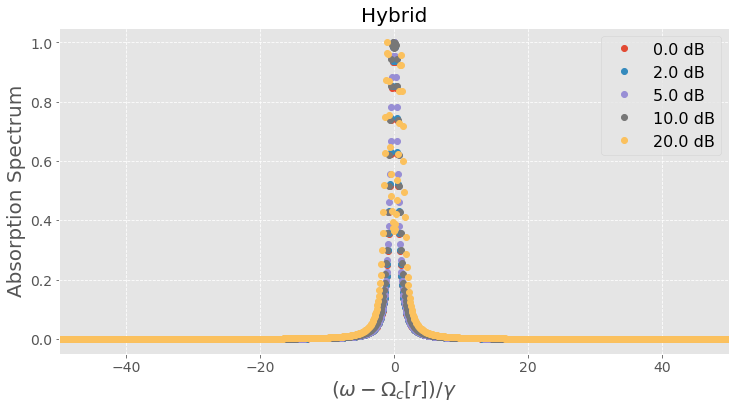

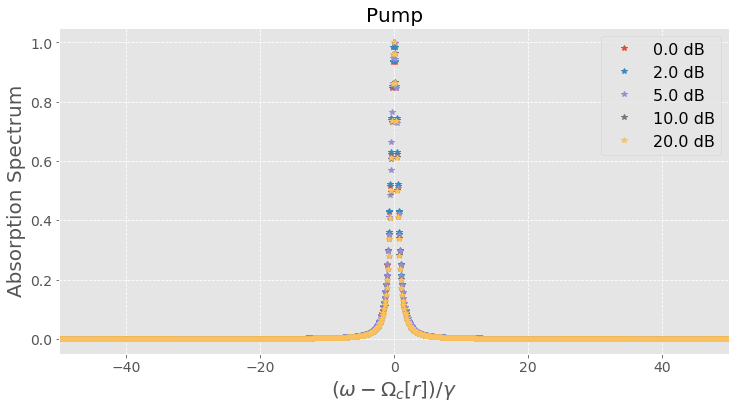

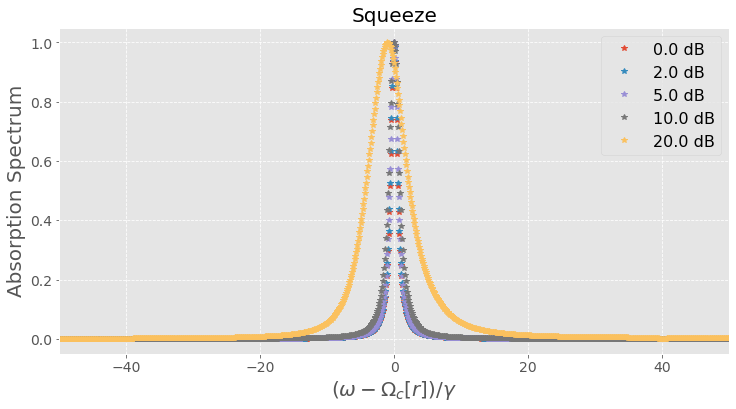

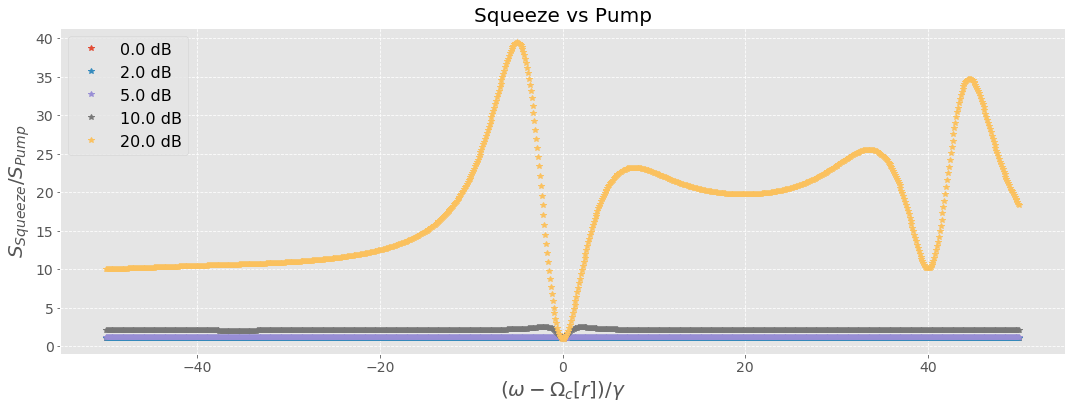

In [14]:
''' Plotting '''
fig1, ax1 = plt.subplots(1, figsize=(12,6))
fig2, ax2 = plt.subplots(1, figsize=(12,6))
fig3, ax3 = plt.subplots(1, figsize=(12,6))
fig4, ax4 = plt.subplots(1, figsize=(18,6))
fitting = False
saving  = False
for ii, S in enumerate(Slist):
    e_pump, w_pump = feeder(S, d_cp, w_cav)
    sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
        
    wdriv = w_drive_list[ii]
    xaxis = (wdriv+sys.Omega())/sys.args['gamma']
#    xaxis = wdriv/sys.args['gamma']
    s_abs = shybrid[ii]/np.max(shybrid[ii])
    ax1.plot(xaxis, s_abs, 'o', label='%.1f dB'%(S), color='C'+str(ii))
    s_abs = spump[ii]/np.max(spump[ii])
    ax2.plot(xaxis, s_abs, '*', label='%.1f dB'%(S), color='C'+str(ii))
    s_abs = ssqueez[ii]/np.max(ssqueez[ii])
    ax3.plot(xaxis, s_abs, '*', label='%.1f dB'%(S), color='C'+str(ii))
    s_abs = ssqueez[ii]/np.max(ssqueez[ii])/(spump[ii]/np.max(spump[ii]))
    ax4.plot(xaxis, s_abs, '*', label='%.1f dB'%(S), color='C'+str(ii))

xlow = -50
xhig = 50
ax1.set_xlim([xlow,xhig])
ax2.set_xlim([xlow,xhig])
ax3.set_xlim([xlow,xhig])

ax1.set_ylabel(r'Absorption Spectrum')
ax1.grid(linestyle='--')
ax1.set_xlabel(r'$(\omega-\Omega_c[r])/\gamma$')
ax1.legend()
ax1.set_title(r'Hybrid')

ax2.set_ylabel(r'Absorption Spectrum')
ax2.grid(linestyle='--')
ax2.set_xlabel(r'$(\omega-\Omega_c[r])/\gamma$')
ax2.legend()
ax2.set_title(r'Pump')

ax3.set_ylabel(r'Absorption Spectrum')
ax3.grid(linestyle='--')
ax3.set_xlabel(r'$(\omega-\Omega_c[r])/\gamma$')
ax3.legend()
ax3.set_title(r'Squeeze')

ax4.set_ylabel(r'$S_{Squeeze}/S_{Pump}$')
ax4.grid(linestyle='--')
ax4.set_xlabel(r'$(\omega-\Omega_c[r])/\gamma$')
ax4.legend()
ax4.set_title(r'Squeeze vs Pump')

plt.show()
if saving:
    fig1.tight_layout()
    fig1.savefig('Comparision_Hybrid')
    fig2.tight_layout()
    fig2.savefig('Comparision_Pump')
    fig3.tight_layout()
    fig3.savefig('Comparision_Squeeze')
    fig4.tight_layout()
    fig4.savefig('Comparision_Squeeze_Pump')

In [15]:
''' All 3 dynamic steadystates & comparison '''
# Set parameters
dlist = list(range(10,30))
dlist = np.array(dlist[0::10])
w_cav = 6e3
d_cp  = 1e3
gamma = 1e-3*d_cp
g     = 0.5*gamma
Slist = np.logspace(-2,1,21)
nth   = 0

# Do not touch
shybrid, spump, ssqueez = [], [], []
sUhybrid, sUsqueez = [], []
for jj, Na in enumerate(dlist):
    print('------------------------')
    hilbert(Na)
    sys   = system(w_cav=w_cav, g=g, gamma=gamma, kappa=gamma)
    sH, sP, sS = [], [], []
    sUh, sUs = [], []
    for ii, S in enumerate(Slist):
        e_pump, w_pump = feeder(S, d_cp, w_cav, printing=False)
        sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump-1000})
        sys.args.update(d_qp=sys.Omega())

        sys.Dynamics(Htype='LRsqueez', Dtype='regular', isDrive=False, nth=nth)
        sH.append(steadystate(sys)) # Hybrid
        sys.Dynamics(Htype='LRrot', Dtype='regular', isDrive=False, nth=nth)
        sP.append(steadystate(sys)) # Pump
        sys.Dynamics(Htype='LRsqueez', Dtype='weird', isDrive=False, nth=nth)
        sS.append(steadystate(sys)) # Squeeze
        
        sys.Dynamics(Htype='LRUsqueez', Dtype='regular', isDrive=False, nth=nth)
        sUh.append(steadystate(sys)) # Unitary Hybrid
        sys.Dynamics(Htype='LRUsqueez', Dtype='Uweird', isDrive=False, nth=nth)
        sUs.append(steadystate(sys)) # Unitary Squeeze
        
    shybrid.append(sH)
    spump.append(sP)
    ssqueez.append(sS)
    sUhybrid.append(sUh)
    sUsqueez.append(sUs)
print('done')

------------------------
dim(H) = 20
------------------------
dim(H) = 40
done


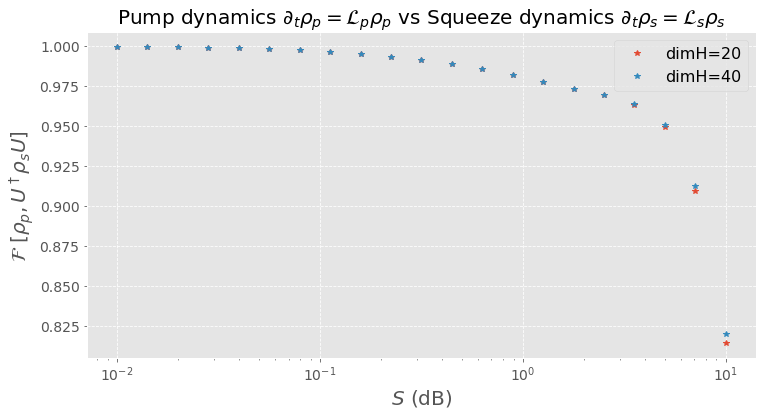

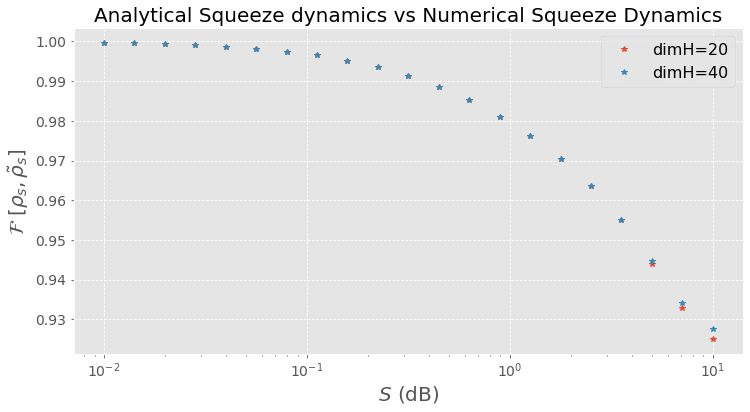

In [14]:
''' Plotting '''
fig1, ax1 = plt.subplots(1, figsize=(12,6))
fig2, ax2 = plt.subplots(1, figsize=(12,6))
#fig3, ax3 = plt.subplots(1, figsize=(12,6))
#fig4, ax4 = plt.subplots(1, figsize=(18,6))
saving  = False

Nd = len(dlist)
NS = len(Slist)

pump2squeez = np.zeros((Nd, NS))
squeez2Usqueez = np.zeros((Nd, NS))


for jj, Na in enumerate(dlist):
    for ii, S in enumerate(Slist):
        e_pump, w_pump = feeder(S, d_cp, w_cav, printing=False)
        sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
        U = qt.tensor(qt.squeeze(Na, sys.args['r']), I2)
        sp = spump[jj][ii]
        ss = U.dag()*ssqueez[jj][ii]*U
        pump2squeez[jj][ii] = qt.fidelity(sp,ss)
        
        sus = sUsqueez[jj][ii]
        ss  = ssqueez[jj][ii]
        squeez2Usqueez[jj][ii] = qt.fidelity(sus,ss)
    
    ax1.semilogx(Slist, pump2squeez[jj], '*', color='C'+str(jj%10), label=r'dimH=%.f'%(2*dlist[jj]))
    
    ax2.semilogx(Slist, hyb2Uhyb[jj], '*', color='C'+str(jj%10), label=r'dimH=%.f'%(2*dlist[jj]))

#[ax1.semilogx(Slist, pump2squeez[jj], '*', label=r'dimH=%.f'%(2*dlist[jj])) for jj in range(Nd)]

ax1.set_ylabel(r'$\mathcal{F}$ $[\rho_p, U^\dagger\rho_sU]$')
ax1.grid(linestyle='--')
ax1.set_xlabel(r'$S$ (dB)')
ax1.legend()
ax1.set_title(r'Pump dynamics $\partial_t\rho_p=\mathcal{L}_p\rho_p$ vs Squeeze dynamics $\partial_t\rho_s = \mathcal{L}_s\rho_s$')

ax2.set_ylabel(r'$\mathcal{F}$ $[\rho_s, \tilde{\rho}_s]$')
ax2.grid(linestyle='--')
ax2.set_xlabel(r'$S$ (dB)')
ax2.legend()
ax2.set_title(r'Analytical Squeeze dynamics vs Numerical Squeeze Dynamics')



plt.show()
if saving:
    fig1.tight_layout()
    fig1.savefig('Comparision_Hybrid')


In [25]:
''' Steadystate Wigners  '''
Na    = 40
w_cav = 6e3
d_cp  = 1e3
gamma = 1e-3*d_cp
g     = 2*gamma

hilbert(Na)
sys   = system(w_cav=w_cav, g=g, gamma=gamma, kappa=gamma)

Slist = np.array([0,2,5,10,20])
hot = False 
span  = 50
shybrid, spump, ssqueez = [], [], []
for ii, S in enumerate(Slist):
    print('------------------------')
    e_pump, w_pump = feeder(S, d_cp, w_cav)
    sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
    sys.args.update(d_qp=sys.Omega())
    
    sys.Dynamics(Htype='LRsqueez', Dtype='regular', isDrive=False, nth=0)
    shybrid.append(steadystate(sys))
    sys.Dynamics(Htype='LRrot', Dtype='regular', isDrive=False, nth=0)
    spump.append(steadystate(sys))
    sys.Dynamics(Htype='LRsqueez', Dtype='weird', isDrive=False, nth=0)
    ssqueez.append(steadystate(sys))
    
print('done')

dim(H) = 80
------------------------
feeder: r=0.00, Omega=1000.00
------------------------
feeder: r=0.23, Omega=902.59
------------------------
feeder: r=0.58, Omega=574.96
------------------------
feeder: r=1.15, Omega=198.02
------------------------
feeder: r=2.30, Omega=20.00
done


feeder: r=0.00, Omega=1000.00


/Users/Vil/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:587: RuntimeWarning: divide by zero encountered in double_scalars
  r = self._mul_scalar(1./other)
/Users/Vil/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:587: RuntimeWarning: divide by zero encountered in double_scalars
  r = self._mul_scalar(1./other)
/Users/Vil/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:587: RuntimeWarning: divide by zero encountered in double_scalars
  r = self._mul_scalar(1./other)
/Users/Vil/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/base.py:587: RuntimeWarning: divide by zero encountered in double_scalars
  r = self._mul_scalar(1./other)


feeder: r=0.23, Omega=902.59
feeder: r=0.58, Omega=574.96
feeder: r=1.15, Omega=198.02
feeder: r=2.30, Omega=20.00


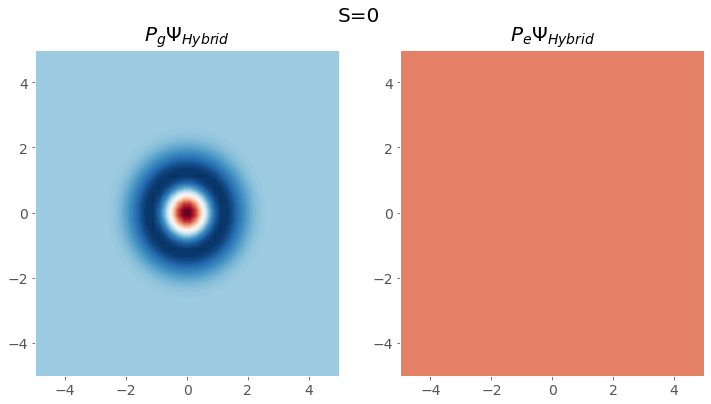

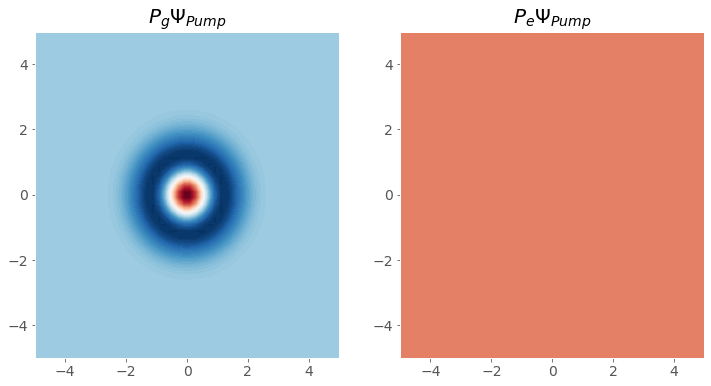

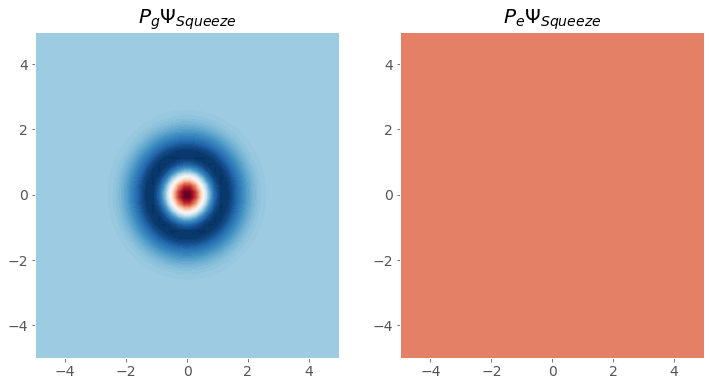

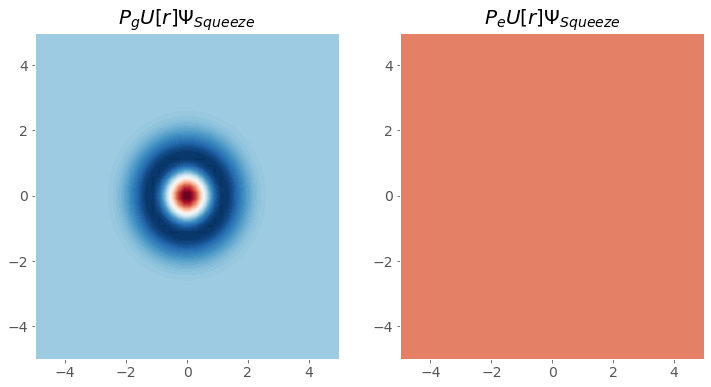

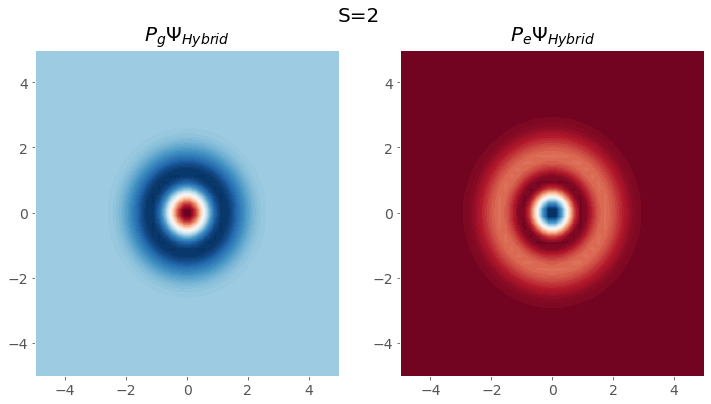

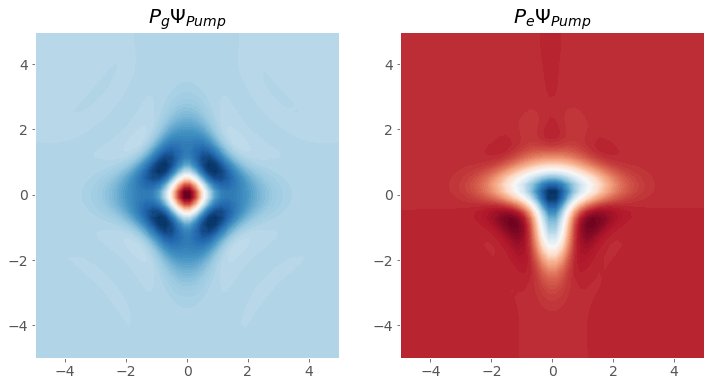

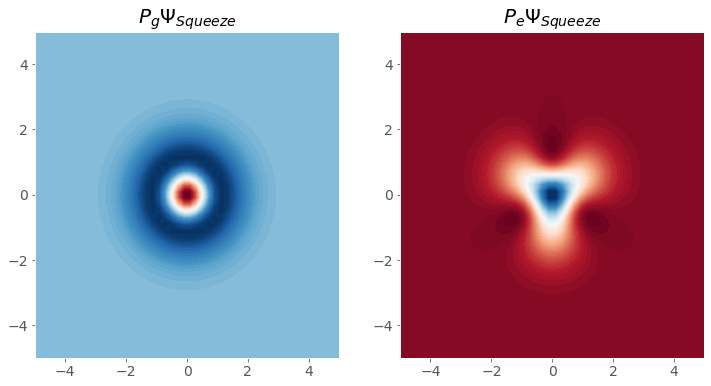

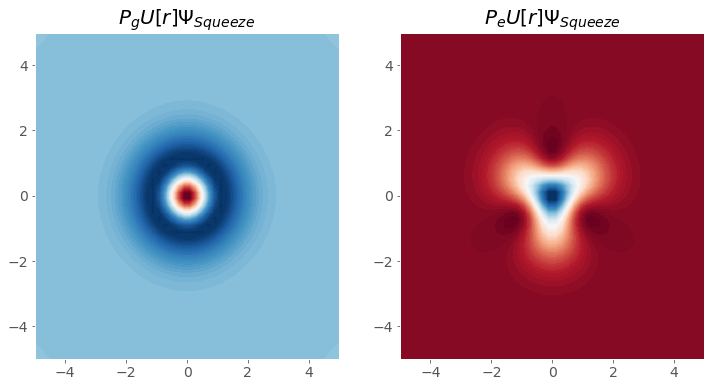

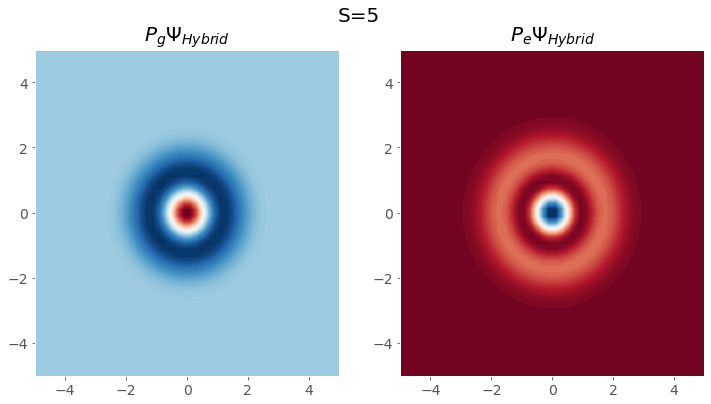

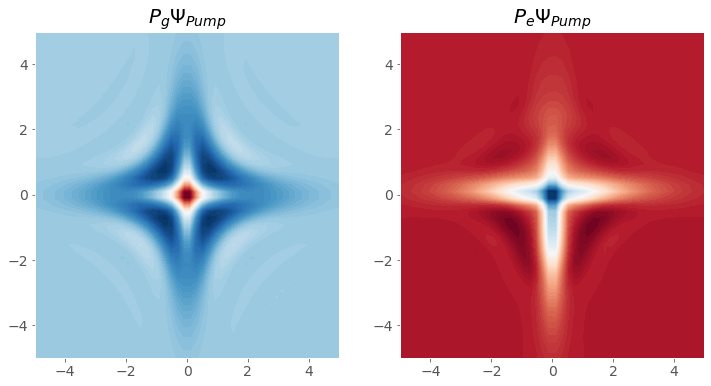

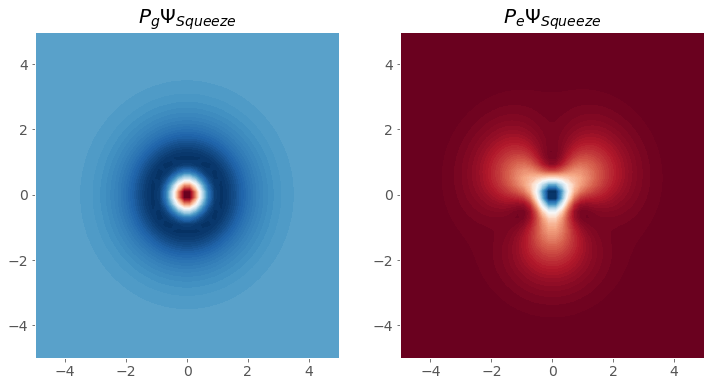

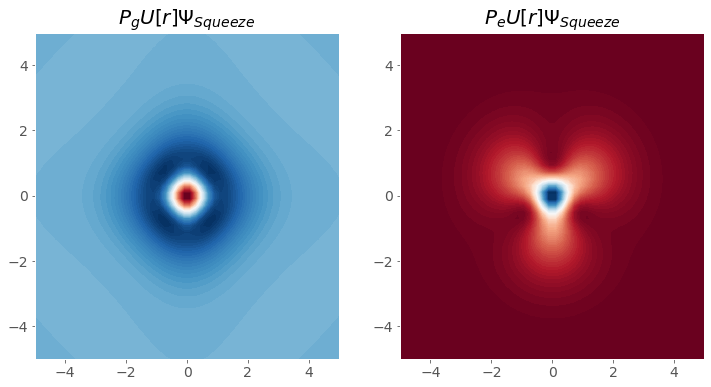

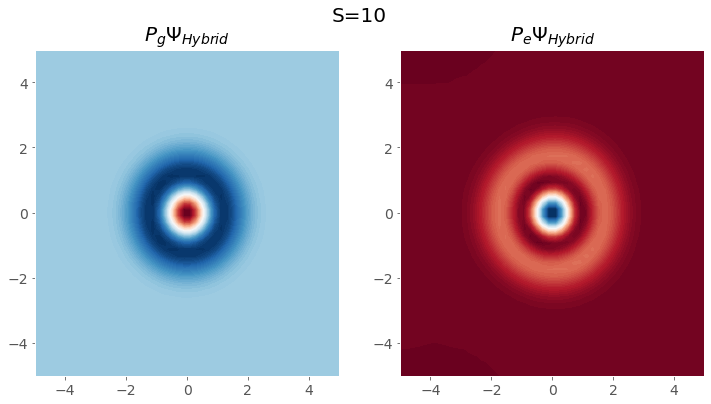

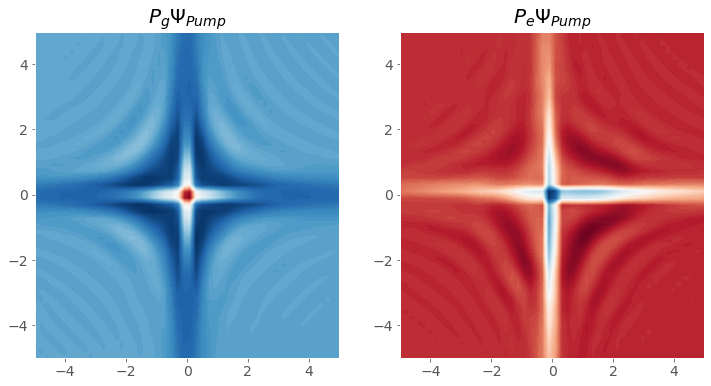

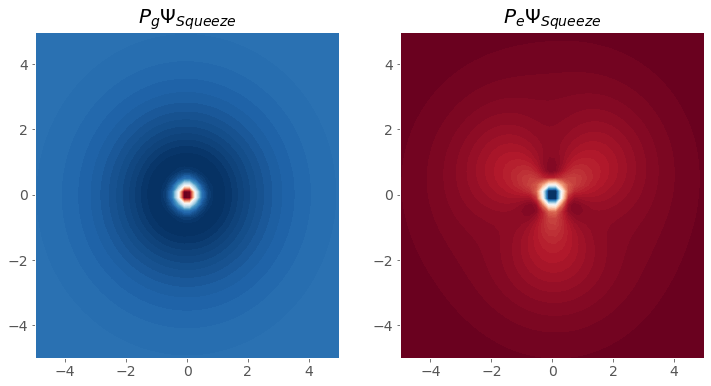

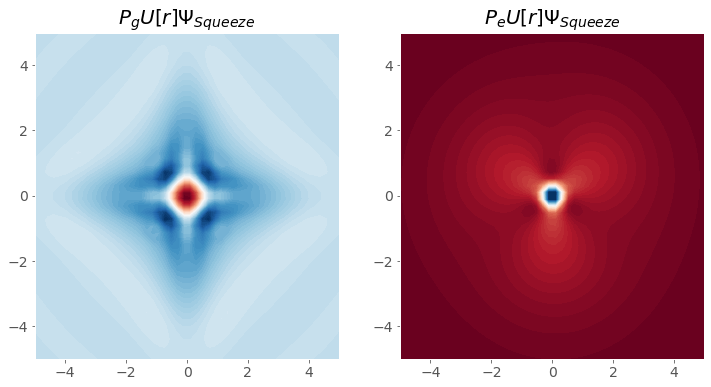

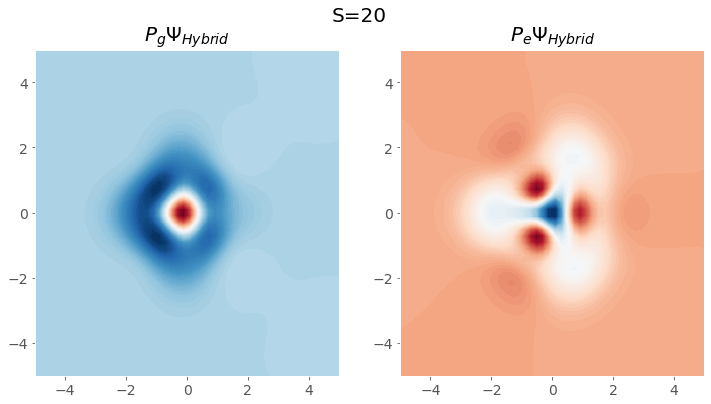

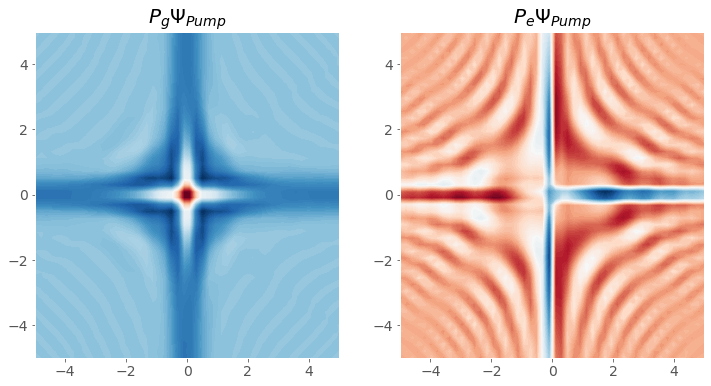

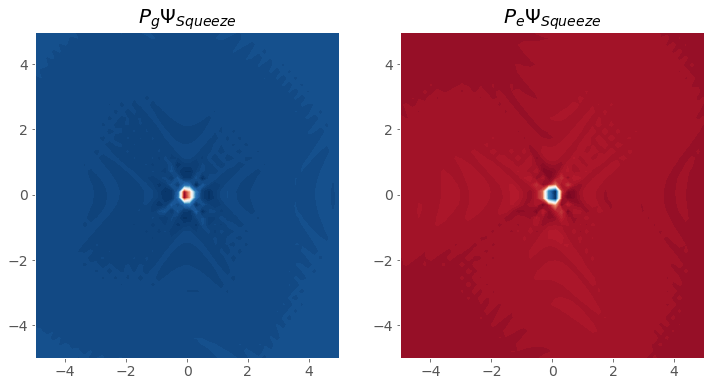

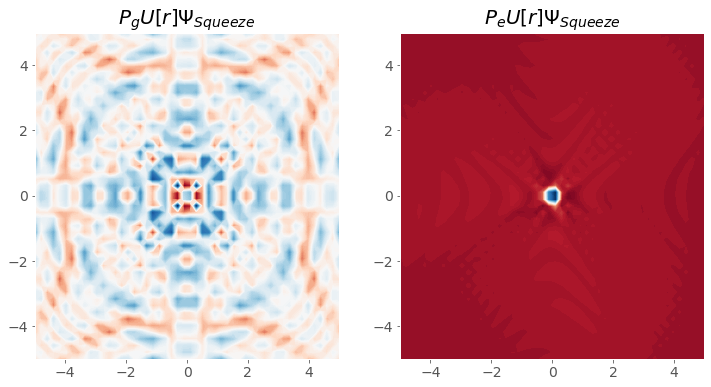

In [26]:
''' Plotting '''

fitting = False
saving = False
xvec = np.linspace(-5, 5, 50)
for ii, S in enumerate(Slist):
    fig1, ax1 = plt.subplots(1,2, figsize=(12,6))
    fig1.suptitle('S=%.f'%S)
    fig2, ax2 = plt.subplots(1,2, figsize=(12,6))
    fig3, ax3 = plt.subplots(1,2, figsize=(12,6))
    fig4, ax4 = plt.subplots(1,2, figsize=(12,6))
    e_pump, w_pump = feeder(S, d_cp, w_cav)
    sys.twopi_update({'e_pump':e_pump, 'w_pump':w_pump})
    
    U = qt.tensor(qt.squeeze(Na, sys.args['r']), I2)
    
    psi = p_g*shybrid[ii]
    psi = psi.unit()
    W = qt.wigner(psi, xvec, xvec)
#    nrm = mpl.colors.Normalize(-W.max(), W.max())
    ax1[0].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)
    psi = p_e*shybrid[ii]
    psi = psi.unit()
    W = qt.wigner(psi, xvec, xvec)
#    nrm = mpl.colors.Normalize(-W.max(), W.max())
    ax1[1].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)
    
    psi = p_g*spump[ii]
    psi = psi.unit()
    W = qt.wigner(psi, xvec, xvec)
#    nrm = mpl.colors.Normalize(-W.max(), W.max())
    ax2[0].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)
    psi = p_e*spump[ii]
    psi = psi.unit()
    W = qt.wigner(psi, xvec, xvec)
#    nrm = mpl.colors.Normalize(-W.max(), W.max())
    ax2[1].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)
    
    psi = p_g*ssqueez[ii]
    psi = psi.unit()
    W = qt.wigner(psi, xvec, xvec)
#    nrm = mpl.colors.Normalize(-W.max(), W.max())
    ax3[0].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)
    psi = p_e*ssqueez[ii]
    psi = psi.unit()
    W = qt.wigner(psi, xvec, xvec)
#    nrm = mpl.colors.Normalize(-W.max(), W.max())
    ax3[1].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)
    
    psi = p_g*U*ssqueez[ii]
    psi = psi.unit()
    W = qt.wigner(psi, xvec, xvec)
#    nrm = mpl.colors.Normalize(-W.max(), W.max())
    ax4[0].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)
    psi = p_e*ssqueez[ii]
    psi = psi.unit()
    W = qt.wigner(psi, xvec, xvec)
#    nrm = mpl.colors.Normalize(-W.max(), W.max())
    ax4[1].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)

    ax1[0].set_title(r'$P_g\Psi_{Hybrid}$')
    ax1[1].set_title(r'$P_e\Psi_{Hybrid}$')

    ax2[0].set_title(r'$P_g\Psi_{Pump}$')
    ax2[1].set_title(r'$P_e\Psi_{Pump}$')

    ax3[0].set_title(r'$P_g\Psi_{Squeeze}$')
    ax3[1].set_title(r'$P_e\Psi_{Squeeze}$')

    ax4[0].set_title(r'$P_gU[r]\Psi_{Squeeze}$')
    ax4[1].set_title(r'$P_eU[r]\Psi_{Squeeze}$')

plt.show()
if saving:
    fig1.tight_layout()
    fig1.savefig('Comparision_Hybrid')
    fig2.tight_layout()
    fig2.savefig('Comparision_Pump')
    fig3.tight_layout()
    fig3.savefig('Comparision_Squeeze')
    fig4.tight_layout()
    fig4.savefig('Comparision_Squeeze_Pump')

In [90]:
dlist = list(range(10,40))
dlist = np.array(Nlist[0])
print(dlist)

10


/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in arctanh
  after removing the cwd from sys.path.
/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
/

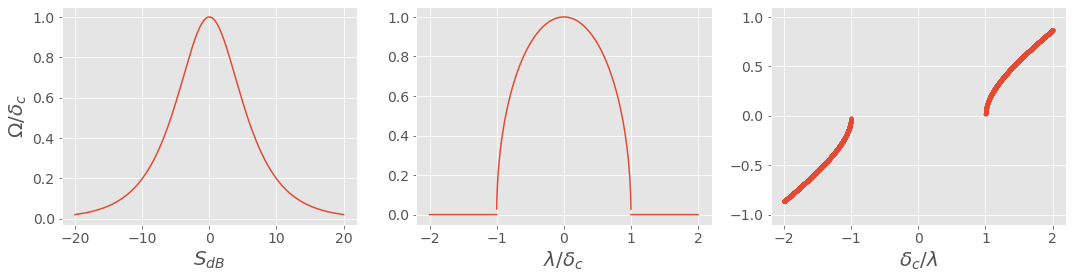

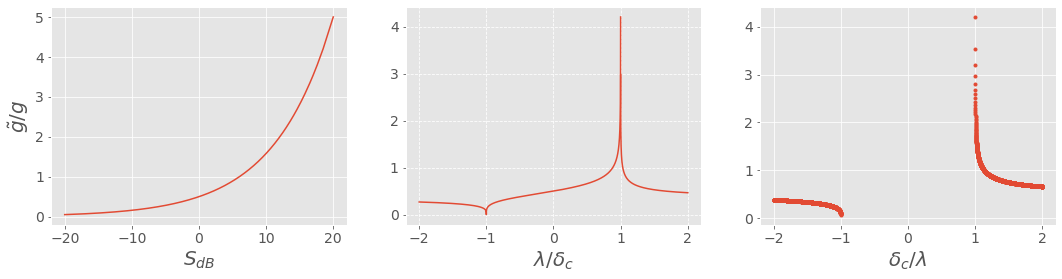

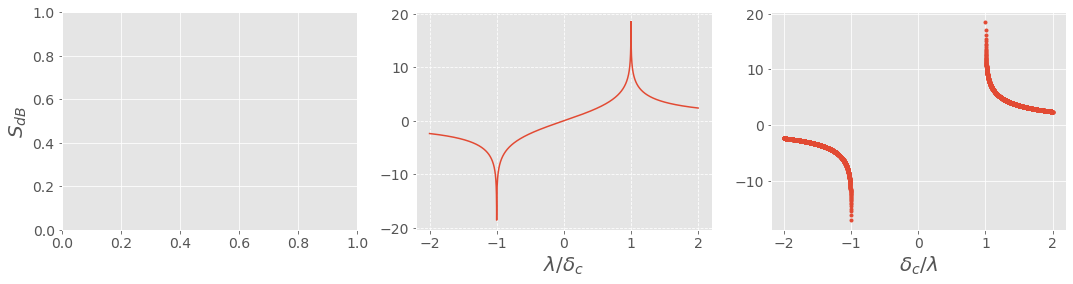

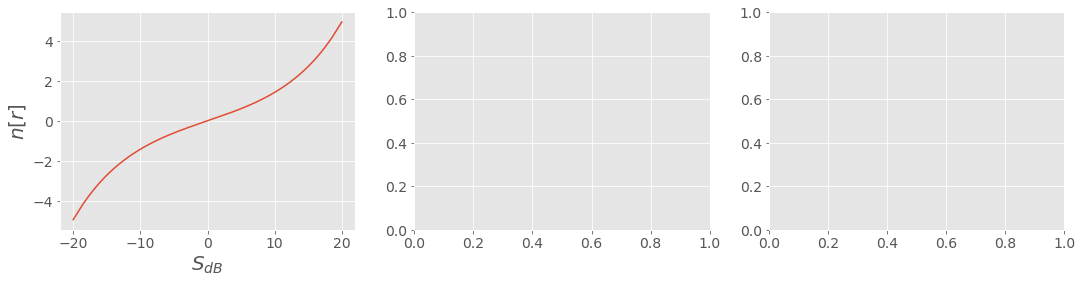

In [208]:
''' Plotting some parameters vs some others '''

def r_param(d_cp, e_pump):
    return (1/2)*np.arctanh(e_pump/d_cp+1j*0)
    #return (1/2)*np.real(np.arctanh(e_pump/d_cp))

def Omega(d_cp, e_pump):
    return d_cp/(np.cosh(2*r_param(d_cp,e_pump))+1j*0)

def Squeez(d_cp, e_pump):
    return 10*np.log10(np.exp(2*r_param(d_cp, e_pump))+1j*0)

def Lambda(d_cp, S):
    return d_cp*np.tanh(np.log(10**(S/10)))

def r_from_S(S):
    return (1/2)*np.log(10**(S/10))


fig, ax = plt.subplots(1,3, figsize=(18,4))
fig2, ax2 = plt.subplots(1,3, figsize=(18,4))
fig3, ax3 = plt.subplots(1,3, figsize=(18,4))
fig4, ax4 = plt.subplots(1,3, figsize=(18,4))

''' SdB '''
d_cp = 1
e_pump = np.linspace(-d_cp, d_cp, 10001)
e_pump = e_pump[1:-1]
ax[0].plot(Squeez(d_cp, e_pump), Omega(d_cp,e_pump))
ax[0].set_xlabel(r'$S_{dB}$')
ax[0].set_ylabel(r'$\Omega/\delta_c$')

ax2[0].plot(Squeez(d_cp, e_pump), (1/2)*np.exp(r_param(d_cp,e_pump)))
ax2[0].set_xlabel(r'$S_{dB}$')
ax2[0].set_ylabel(r'$\tilde{g}/g$')

ax3[0].set_ylabel(r'$S_{dB}$')

ax4[0].plot(Squeez(d_cp, e_pump), np.sinh(r_param(d_cp,e_pump)))
ax4[0].set_xlabel(r'$S_{dB}$')
ax4[0].set_ylabel(r'$n[r]$')

''' lambda/d_c '''
d_cp = 1
e_pump = np.linspace(-2*d_cp, 2*d_cp, 10001)
e_pump = e_pump[1:-1]
ax[1].plot(e_pump, Omega(d_cp,e_pump))
ax[1].set_xlabel(r'$\lambda/\delta_c$')

ax2[1].plot(e_pump, (1/2)*np.exp(r_param(d_cp,e_pump)))
ax2[1].grid(linestyle='--')
ax2[1].set_xlabel(r'$\lambda/\delta_c$')

ax3[1].plot(e_pump, Squeez(d_cp,e_pump))
ax3[1].grid(linestyle='--')
ax3[1].set_xlabel(r'$\lambda/\delta_c$')



''' d_c/lambda'''
d_cp = np.linspace(-1, 1, 10001)
e_pump = d_cp[-1]*0.5
i0 = np.argmin(np.abs(d_cp-e_pump))
i1 = np.argmin(np.abs(d_cp+e_pump))
d_cp2 = [d_cp[ii] for ii in range(i1-1)]
d_cp2 += [d_cp[ii] for ii in range(i0+1,len(d_cp))]
ax[2].plot(d_cp2/e_pump, Omega(d_cp2,e_pump), '.')
ax[2].set_xlabel(r'$\delta_c/\lambda$')
ax[2].set_ylim([-1.1,1.1])

ax2[2].plot(d_cp2/e_pump, (1/2)*np.exp(r_param(d_cp2,e_pump)), '.')
ax2[2].set_xlabel(r'$\delta_c/\lambda$')

ax3[2].plot(d_cp2/e_pump, Squeez(d_cp2,e_pump), '.')
ax3[2].set_xlabel(r'$\delta_c/\lambda$')



plt.show()







/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


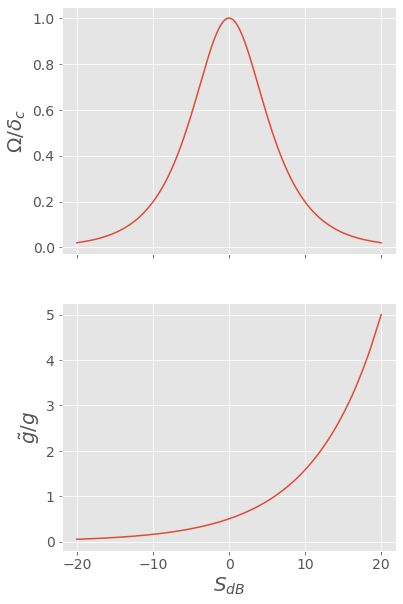

/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


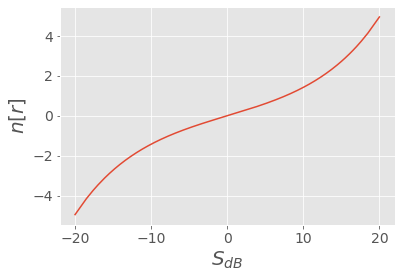

In [237]:
''' Clean plot Omega and gtilde '''
saving = False

fig, ax = plt.subplots(2,1, figsize=(6,10))

d_cp = 1
e_pump = np.linspace(-d_cp, d_cp, 10001)
e_pump = e_pump[1:-1]
ax[0].plot(Squeez(d_cp, e_pump), Omega(d_cp,e_pump))
ax[0].set_ylabel(r'$\Omega/\delta_c$')
ax[0].xaxis.set_ticklabels([])

ax[1].plot(Squeez(d_cp, e_pump), (1/2)*np.exp(r_param(d_cp,e_pump)))
ax[1].set_xlabel(r'$S_{dB}$')
ax[1].set_ylabel(r'$\tilde{g}/g$')

plt.show()
fig.tight_layout()
fig.savefig('Omega_g_vs_S.png')


fig2, ax2 = plt.subplots(figsize=(6,4))

d_cp = 1
e_pump = np.linspace(-d_cp, d_cp, 10001)
e_pump = e_pump[1:-1]
ax2.plot(Squeez(d_cp, e_pump), np.sinh(r_param(d_cp,e_pump)))
ax2.set_ylabel(r'$n[r]$')
ax2.set_xlabel(r'$S_{dB}$')

plt.show()
if saving:
    fig2.tight_layout()
    fig2.savefig('nth_vs_S.png')

In [91]:
''' Vacuum Rabi Splitting   '''
w_cav = 6e3
gamma = 1
sys   = system(w_cav=w_cav, gamma=gamma, kappa=gamma)
Slist = np.linspace(0,10,6)
#print(sys.print_args('inline'))
g_list = np.array([0, 1, 2])

span  = 10
style = 'JC'
s_abs_list = []
for ii, g in enumerate(g_list):
    print(g)
    sys.twopi_update({'g':g})
    if style is 'JC':
        w_drive = 2*np.pi*np.linspace(-span,+span, 501)
    elif style is 'Rabi':
        w_drive = - sys.args['w_qubit'] + 2*np.pi*np.linspace(-span,+span, 501)
    sys.Dynamics(Htype=style, Dtype='regular', isDrive=False)
    s_abs = qubit_spectrum(sys, w_drive)
    s_abs_list.append(s_abs)
print('done')

0
1
2
done


/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


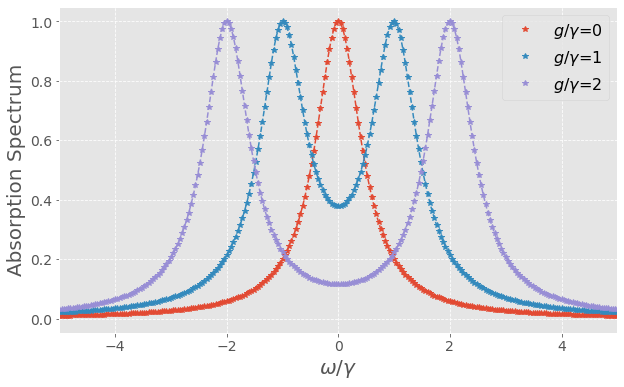

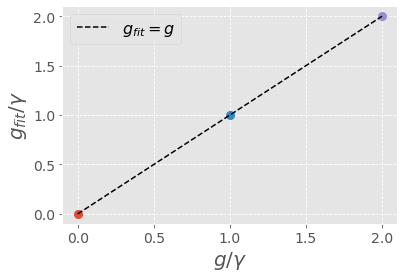

In [94]:
''' Plotting VRS '''
saving = False
fitting = True
fig1, ax1 = plt.subplots(figsize=(10,6))
fig2, ax2 = plt.subplots(figsize=(6,4))
for ii, g in enumerate(g_list[:]):
#    xaxis = w_drive/2/np.pi
    if style is 'JC':
        xaxis = (w_drive)/sys.args['gamma']
    elif style is 'Rabi':
        xaxis = (w_drive+sys.args['w_qubit'])/sys.args['gamma']
    s_abs = s_abs_list[ii]/np.max(s_abs_list[ii])
    ax1.plot(xaxis, s_abs, '*', label=r'$g/\gamma$=%.f'%(g), color='C'+str(ii))
    ax1.set_xlim([-5,5])    
    if fitting:
        p0    = [0,sys.args['gamma'],1/2,g]
        popt, pcov = sc.curve_fit(func_double_lor, w_drive, s_abs, p0=p0)
        xaxis_th = np.linspace(xaxis[0], xaxis[-1], 101)
        ax1.plot(xaxis, func_double_lor(w_drive,*popt), '--', color='C'+str(ii))
        ax2.plot(g, np.abs(popt[3])/2/np.pi, 'o', markersize=8)

    
ax2.plot(np.linspace(0,2), np.linspace(0,2), 'k--', label=r'$g_{fit}=g$')
ax1.set_ylabel(r'Absorption Spectrum')
ax1.grid(linestyle='--')
ax1.set_xlabel(r'$\omega/\gamma$')
ax1.legend()
ax2.set_ylabel(r'$g_{fit}/\gamma$')
ax2.grid(linestyle='--')
ax2.set_xlabel(r'$g/\gamma$')
ax2.legend()
plt.show()

if saving:
    fig1.tight_layout()
    fig1.savefig('VRS_JC_spectrum.png')
    fig2.tight_layout()
    fig2.savefig('VRS_JC_g.png')
    #fig.savefig(my_path+my_file) 


-1.497240354223
-1.0913411108191593
-0.9417250878410466
-0.8471668868302724
-0.7774671202499244
-0.7219871851803888
-0.6757225369319038
-0.6359151227358945
-0.6008820781708143
-0.5695204872514957
-0.5410680526363636
-0.514975751818057
-0.4908349460476585
-0.46833318899446524
-0.44722615922167297
-0.4273191343044736
-0.40845436052930256
-0.39050220066828617
-0.37335477971089814
-0.35692132751456407
-0.3411247018650926
-0.32589875001978774
-0.3111862770426632
-0.2969374606413712
-0.28310859952435347
-0.26966111429006356
-0.2565607418994082
-0.24377688022172303
-0.23128205012706396
-0.2190514505202017
-0.2070625875011399
-0.19529496311819508
-0.18372981238056238
-0.1723498796149284
-0.16113922709403988
-0.15008307028295756
-0.1391676351481033
-0.1283800338330671
-0.11770815568070701
-0.10714057111578117
-0.09666644632792222
-0.08627546703509477
-0.07595776988090407
-0.06570388023909463
-0.055504655375921946
-0.04535123206399078
-0.03523497785596338
-0.025147445318144092
-0.015080328596114

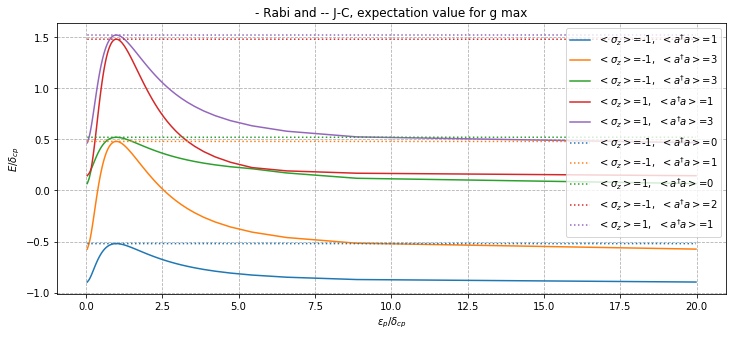

In [46]:
''' Spectrum LRroat vs e_pump '''
w_qubit = 6.002e3 
w_cav   = 6e3
w_pump  = 2*w_cav-1e2
sys     = system(w_qubit=w_qubit,w_cav=w_cav, w_pump=w_pump)
d_cp    = sys.freqs('d_cp')
sweep_list  = np.linspace(-0.995*d_cp, 0.995*d_cp,100)
sweep_list2 = sys.args['g']*np.exp((1/2)*np.arctanh(sweep_list/d_cp))
nrj_list, state_list = eigenspectrum(sys, 'LRrotated', 'e_pump', sweep_list)
#nrj_rwa_list, state_rwa_list = eigenspectrum(sys, 'Rabi', 'g', sweep_list2)
nrj_rwa_list, state_rwa_list = eigenspectrum(sys, 'LRsqueez', 'e_pump', sweep_list)
print('done')
#print(sweep_list2)

''' Plotting '''
Nst   = 5
xscal = np.abs(sys.freqs('d_cp'))
yscal = d_cp
xaxis = sweep_list/xscal
xaxis = np.exp(np.arctanh(sweep_list/d_cp))
fig, ax = plt.subplots(figsize=(12,5))
ex_sz = [qt.expect(sz ,state_list[ii][-1]) for ii in range(Nst)]
ex_aa = [qt.expect(a.dag()*a ,state_list[ii][-1]) for ii in range(Nst)]
label = [r'$<\sigma_z>$=%.0f,  $<a^\dag a>$=%.0f'%(ex_sz[ii],ex_aa[ii]) for ii in range(Nst)]
[ax.plot(xaxis, nrj_list[ii]/yscal, color='C'+str(ii), label=label[ii]) for ii in range(Nst)]
ex_sz = [qt.expect(sz ,state_rwa_list[ii][-1]) for ii in range(Nst)]
ex_aa = [qt.expect(a.dag()*a ,state_rwa_list[ii][-1]) for ii in range(Nst)]
label = [r'$<\sigma_z>$=%.0f,  $<a^\dag a>$=%.0f'%(ex_sz[ii],ex_aa[ii]) for ii in range(Nst)]
[ax.plot(xaxis, nrj_rwa_list[ii]/yscal, ':', color='C'+str(ii), label=label[ii]) for ii in range(Nst)]
#ax.axvline(1, c='k')
#ax.axvline(sys.args['w_qubit']/xscal, c='k')
#ax[0].set_xlim([-100,1000])
ax.set_xlabel(r'$\varepsilon_p / \delta_{cp}$')
ax.set_ylabel(r'$E / \delta_{cp}$')
ax.set_title(r'- Rabi and -- J-C, expectation value for g max')
ax.grid(linestyle='--')
ax.legend()

plt.show()

-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


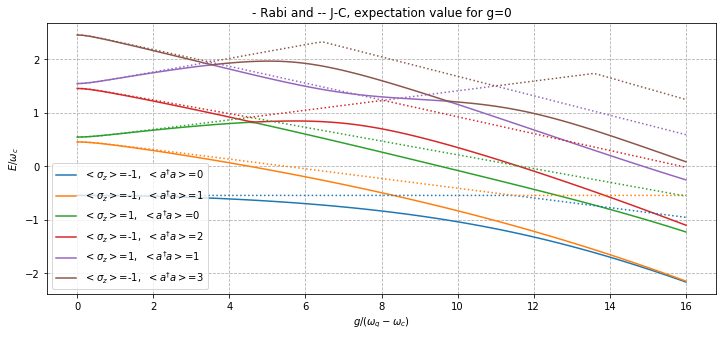

In [2]:
''' Spectrum Rabi vs g '''
sys = system(w_qubit=6e3,w_cav=5.5e3)
sweep_list = np.linspace(1,8000,100)
nrj_list, state_list = eigenspectrum(sys, 'Rabi', 'g', sweep_list)
nrj_rwa_list, state_rwa_list = eigenspectrum(sys, 'JC', 'g', sweep_list)
print('done')

''' Plotting '''
Nst   = 6
xscal = sys.freqs('w_qubit')-sys.freqs('w_cav')
yscal = sys.freqs('w_cav')
xaxis = sweep_list/xscal
ex_sz = [qt.expect(sz ,state_list[ii][0]) for ii in range(Nst)]
ex_aa = [qt.expect(a.dag()*a ,state_list[ii][0]) for ii in range(Nst)]
label = [r'$<\sigma_z>$=%.0f,  $<a^\dag a>$=%.0f'%(ex_sz[ii],ex_aa[ii]) for ii in range(Nst)]
fig, ax = plt.subplots(figsize=(12,5))
[ax.plot(xaxis, nrj_list[ii]/yscal, color='C'+str(ii), label=label[ii]) for ii in range(Nst)]
[ax.plot(xaxis, nrj_rwa_list[ii]/yscal, ':', color='C'+str(ii)) for ii in range(Nst)]
#ax.axvline(1, c='k')
#ax.axvline(sys.args['w_qubit']/xscal, c='k')
#ax[0].set_xlim([-100,1000])
ax.set_xlabel(r'$g / (\omega_q-\omega_c)$')
ax.set_ylabel(r'$E / \omega_c$')
ax.set_title(r'- Rabi and -- J-C, expectation value for g=0')
ax.grid(linestyle='--')
ax.legend()

plt.show()

wq=6000.0,  wc=6000.0,  g=1.0,  gamma=5.0,  kappa=5.0,  wp=12000.0,  ep=0.0,  wd=6000.0,  ed=2.0,  dcp=0.0,  dqp=3000.0


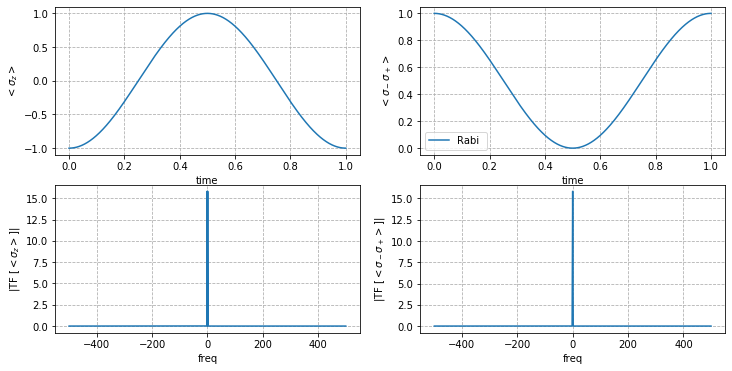

In [5]:
''' Time and frequency visualisation '''

sys = system(w_qubit=6e3, g=1e0, e_drive=2)
print(sys.print_args('inline'))
sys.Dynamics(Htype='TLS', isD=False)

H     = sys.operators['H']
psi0  = vac
times = np.linspace(0,1,1001)
D     = sys.operators['D']
obs   = [sz, sm*sm.dag()]
args  = sys.args

result = qt.mesolve(H, psi0, times, D, obs, args=args, options=options)

sz_fft   = nf.fftshift(nf.fft(result.expect[0], norm='ortho'))
smsp_fft = nf.fftshift(nf.fft(result.expect[1], norm='ortho'))
freqs    = nf.fftshift(nf.fftfreq(len(times), times[1]-times[0]))


fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].plot(times, result.expect[0], '-')
ax[0,0].set_ylabel(r'$<\sigma_z>$')
ax[0,0].grid(linestyle='--')
ax[0,0].set_xlabel('time')
ax[1,0].plot(freqs, np.abs(sz_fft))
ax[1,0].set_ylabel(r'|TF $[<\sigma_z>]$|')
ax[1,0].set_xlabel('freq')
ax[1,0].grid(linestyle='--')
ax[0,1].plot(times, result.expect[1], label='Rabi ')
ax[0,1].legend()
ax[0,1].set_ylabel(r'$<\sigma_-\sigma_+>$')
ax[0,1].grid(linestyle='--')
ax[0,1].set_xlabel('time')
ax[1,1].plot(freqs[:], np.abs(smsp_fft[:]), label='Rabi ')
ax[1,1].set_ylabel(r'|TF $[<\sigma_-\sigma_+>]$|')
ax[1,1].set_xlabel('freq')
ax[1,1].grid(linestyle='--')
#ax[1,1].set_ylim([0,0.2])




In [137]:
skip = ['e_drive', 'w_drive']
print(skip)

['e_drive', 'w_drive']


In [134]:
for keys in sys.args.keys():
    print(keys)

w_qubit
w_cav
g
gamma
kappa
w_pump
e_pump
w_drive
e_drive
d_cp
d_qp
r
O
SdB


In [169]:
np.linspace(0,20,6)

array([ 0.,  4.,  8., 12., 16., 20.])

In [311]:
a = ['2','6']
for ii in range(10):
    if str(ii) in a:
        print(ii)

2
6


/Users/alicedagnan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'cnorm'
  # Remove the CWD from sys.path while we load stuff.


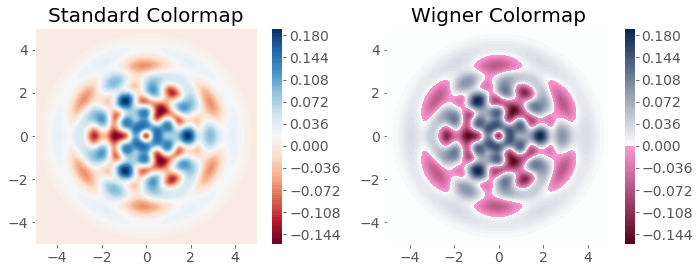

In [37]:
import matplotlib as mpl
from matplotlib import cm

psi = (qt.basis(10, 0) + qt.basis(10, 3) + qt.basis(10, 9)).unit()
xvec = np.linspace(-5, 5, 500)
W = qt.wigner(psi, xvec, xvec)
wmap = qt.wigner_cmap(W) # Generate Wigner colormap
nrm = mpl.colors.Normalize(-W.max(), W.max())
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt1 = axes[0].contourf(xvec, xvec, W, 100, cmap=cm.RdBu, cnorm=nrm)
axes[0].set_title("Standard Colormap")
cb1 = fig.colorbar(plt1, ax=axes[0])
plt2 = axes[1].contourf(xvec, xvec, W, 100, cmap=wmap) # Apply Wigner ˓→colormap
axes[1].set_title("Wigner Colormap")
cb2 = fig.colorbar(plt2, ax=axes[1])
fig.tight_layout()
plt.show()


8.685889638065037


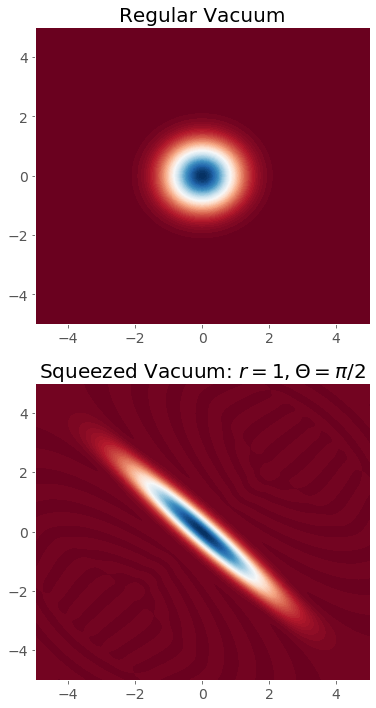

In [93]:
import matplotlib as mpl
from matplotlib import cm

Naa = 30
psi = (qt.basis(Naa, 0)).unit()
xvec = np.linspace(-5, 5, 500)

fig, axes = plt.subplots(2, 1, figsize=(6, 12))

W = qt.wigner(psi, xvec, xvec)
nrm = mpl.colors.Normalize(-W.max(), W.max())
plt1 = axes[0].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) #, cnorm=nrm)
axes[0].set_title(r'Regular Vacuum')
#cb1 = fig.colorbar(plt1, ax=axes[0])

amp = 1
print(10*np.log10(np.exp(2*amp)))
ang = 90
sp  = amp*np.exp(1j*ang/180*np.pi)
U = qt.squeeze(Naa, sp)
psi = U*psi
W = qt.wigner(psi, xvec, xvec)
nrm = mpl.colors.Normalize(-W.max(), W.max())
plt2 = axes[1].contourf(xvec, xvec, W, 100, cmap=cm.RdBu) # Apply Wigner ˓→colormap
axes[1].set_title(r'Squeezed Vacuum: $r=1, \Theta=\pi/2$')
#cb2 = fig.colorbar(plt2, ax=axes[1])
plt.show()

plt.show()
fig.tight_layout()
fig.savefig('wigner.png')